# Hybrid Classification Pipeline

In [1]:
import pandas as pd
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from transformers import RobertaTokenizer, RobertaModel, Trainer, TrainingArguments, EarlyStoppingCallback
from torch.utils.data import Dataset
import warnings
warnings.filterwarnings('ignore')
os.environ["WANDB_DISABLED"] = "true"

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple Silicon GPU (MPS)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using NVIDIA GPU (CUDA)")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using NVIDIA GPU (CUDA)


In [ ]:
df = pd.read_csv("../OBC_Cleaned.csv")
df = df.dropna(how="all")

print(f"Loaded {len(df)} rows")
print(f"\nColumns: {list(df.columns)}")
print(f"\nVerdict distribution:\n{df['Verdict'].value_counts()}")
print(f"\nOffence distribution:\n{df['Offence'].value_counts()}")

Mounted at /content/drive
Loaded 49365 rows

Columns: ['Trial_ID', 'Date', 'Defendant_Gender', 'Num_Defendants', 'Victim_Gender', 'Num_Victims', 'Offence', 'Offence_Subcategory', 'Verdict', 'Text_Length', 'Trial_Text', 'Year']

Verdict distribution:
Verdict
guilty       35487
notGuilty    13878
Name: count, dtype: int64

Offence distribution:
Offence
theft            37033
deception         2956
violentTheft      2433
royalOffences     2135
sexual            1434
breakingPeace     1319
kill              1205
miscellaneous      654
damage             196
Name: count, dtype: int64


In [3]:
# CSV text is already fully processed - just ensure it's string type
df['Trial_Text'] = df['Trial_Text'].astype(str)

print(f"Text loaded from CSV (already preprocessed)")
print(f"Sample text: {df['Trial_Text'].iloc[0][:200]}...")
print(f"Average text length: {df['Trial_Text'].str.len().mean():.0f} characters")

Text loaded from CSV (already preprocessed)
Sample text: First London Jury. - Before Mr. Recorder. 498. THOMAS SAGGERS and JEREMIAH CRANE were indicted for stealing, on the 22nd of January , at St. Alban, Wood-street , 7 pieces of flannel, value 23l., the g...
Average text length: 3087 characters


In [4]:
df = df[df['Verdict'].isin(['guilty', 'notGuilty'])].copy()
df = df[df['Offence'] != 'Unknown'].copy()
df = df.drop_duplicates(subset="Trial_ID", keep="first")
df = df.drop_duplicates(subset="Trial_Text", keep="first")

df_not_guilty = df[df['Verdict'] == 'notGuilty']
df_guilty = df[df['Verdict'] == 'guilty']
min_count = min(len(df_not_guilty), len(df_guilty))

print(f"Before balancing: notGuilty={len(df_not_guilty)}, guilty={len(df_guilty)}")

df_not_guilty_balanced = df_not_guilty.sample(n=min_count, random_state=42)
df_guilty_balanced = df_guilty.sample(n=min_count, random_state=42)
df = pd.concat([df_not_guilty_balanced, df_guilty_balanced]).reset_index(drop=True)

print(f"After balancing: {len(df)} total rows")
print(f"\n{df['Verdict'].value_counts()}")

Before balancing: notGuilty=13878, guilty=35487
After balancing: 27756 total rows

Verdict
notGuilty    13878
guilty       13878
Name: count, dtype: int64


In [5]:
label_map = {"guilty": 1, "notGuilty": 0}
df["Label"] = df["Verdict"].map(label_map)

offence_encoder = LabelEncoder()
df["Offence_Encoded"] = offence_encoder.fit_transform(df["Offence"])

offence_sub_encoder = LabelEncoder()
df["Offence_Subcategory_Encoded"] = offence_sub_encoder.fit_transform(df["Offence_Subcategory"])

def_gender_encoder = LabelEncoder()
df["Defendant_Gender_Encoded"] = def_gender_encoder.fit_transform(df["Defendant_Gender"])

vic_gender_encoder = LabelEncoder()
df["Victim_Gender_Encoded"] = vic_gender_encoder.fit_transform(df["Victim_Gender"])

scaler = StandardScaler()
df[["Year_Scaled", "Num_Defendants_Scaled", "Num_Victims_Scaled", "Text_Length_Scaled"]] = scaler.fit_transform(
    df[["Year", "Num_Defendants", "Num_Victims", "Text_Length"]]
)

print("="*60)
print("METADATA FEATURES SUMMARY")
print("="*60)
print(f"\nCategorical (one-hot encoded):")
print(f"  - Offence: {len(offence_encoder.classes_)} categories")
print(f"  - Offence_Subcategory: {len(offence_sub_encoder.classes_)} categories")
print(f"  - Defendant_Gender: {len(def_gender_encoder.classes_)} categories")
print(f"  - Victim_Gender: {len(vic_gender_encoder.classes_)} categories")

print(f"\nNumerical (scaled):")
print(f"  - Year: [{df['Year'].min()}, {df['Year'].max()}]")
print(f"  - Num_Defendants: [{df['Num_Defendants'].min()}, {df['Num_Defendants'].max()}]")
print(f"  - Num_Victims: [{df['Num_Victims'].min()}, {df['Num_Victims'].max()}]")
print(f"  - Text_Length: [{df['Text_Length'].min()}, {df['Text_Length'].max()}]")

total_metadata = 4 + len(offence_encoder.classes_) + len(offence_sub_encoder.classes_) + len(def_gender_encoder.classes_) + len(vic_gender_encoder.classes_)
print(f"\nTOTAL METADATA FEATURES: {total_metadata}")
print(f"   (4 numerical + {len(offence_encoder.classes_)} + {len(offence_sub_encoder.classes_)} + {len(def_gender_encoder.classes_)} + {len(vic_gender_encoder.classes_)} categorical)")

METADATA FEATURES SUMMARY

Categorical (one-hot encoded):
  - Offence: 9 categories
  - Offence_Subcategory: 54 categories
  - Defendant_Gender: 4 categories
  - Victim_Gender: 4 categories

Numerical (scaled):
  - Year: [1720, 1913]
  - Num_Defendants: [0, 35]
  - Num_Victims: [0, 22]
  - Text_Length: [0, 498157]

TOTAL METADATA FEATURES: 75
   (4 numerical + 9 + 54 + 4 + 4 categorical)


In [6]:
class HybridCourtDataset(Dataset):
    def __init__(self, texts, labels, metadata_dict, tokenizer, max_len=512):
        self.texts = texts
        self.labels = labels
        self.metadata_dict = metadata_dict
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )

        item = {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

        numerical = torch.tensor([
            self.metadata_dict['year_scaled'][idx],
            self.metadata_dict['num_defendants_scaled'][idx],
            self.metadata_dict['num_victims_scaled'][idx],
            self.metadata_dict['text_length_scaled'][idx]
        ], dtype=torch.float)

        offence_onehot = torch.zeros(self.metadata_dict['num_offence_classes'], dtype=torch.float)
        offence_onehot[self.metadata_dict['offences_encoded'][idx]] = 1.0

        offence_sub_onehot = torch.zeros(self.metadata_dict['num_offence_sub_classes'], dtype=torch.float)
        offence_sub_onehot[self.metadata_dict['offences_sub_encoded'][idx]] = 1.0

        def_gender_onehot = torch.zeros(self.metadata_dict['num_def_gender_classes'], dtype=torch.float)
        def_gender_onehot[self.metadata_dict['def_gender_encoded'][idx]] = 1.0

        vic_gender_onehot = torch.zeros(self.metadata_dict['num_vic_gender_classes'], dtype=torch.float)
        vic_gender_onehot[self.metadata_dict['vic_gender_encoded'][idx]] = 1.0

        item["metadata"] = torch.cat([numerical, offence_onehot, offence_sub_onehot, def_gender_onehot, vic_gender_onehot])
        return item

    def __len__(self):
        return len(self.labels)

In [7]:
class HybridRobertaClassifier(nn.Module):
    def __init__(self, num_metadata_features, num_labels=2, dropout=0.3):
        super(HybridRobertaClassifier, self).__init__()

        self.roberta = RobertaModel.from_pretrained("roberta-base")
        self.text_hidden_size = self.roberta.config.hidden_size

        self.metadata_encoder = nn.Sequential(
            nn.Linear(num_metadata_features, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 32),
            nn.ReLU(),
        )

        combined_size = self.text_hidden_size + 32
        self.fusion = nn.Sequential(
            nn.Linear(combined_size, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
        )

        self.classifier = nn.Linear(64, num_labels)

    def forward(self, input_ids, attention_mask, metadata, labels=None):
        roberta_output = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        text_features = roberta_output.last_hidden_state[:, 0, :]

        metadata_features = self.metadata_encoder(metadata)

        combined = torch.cat([text_features, metadata_features], dim=1)
        fused = self.fusion(combined)

        logits = self.classifier(fused)

        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)

        return {"loss": loss, "logits": logits}

In [8]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    return {"accuracy": acc, "f1": f1}

In [9]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

texts = df["Trial_Text"].tolist()
labels = df["Label"].tolist()

metadata_dict = {
    'year_scaled': df["Year_Scaled"].tolist(),
    'num_defendants_scaled': df["Num_Defendants_Scaled"].tolist(),
    'num_victims_scaled': df["Num_Victims_Scaled"].tolist(),
    'text_length_scaled': df["Text_Length_Scaled"].tolist(),
    'offences_encoded': df["Offence_Encoded"].tolist(),
    'offences_sub_encoded': df["Offence_Subcategory_Encoded"].tolist(),
    'def_gender_encoded': df["Defendant_Gender_Encoded"].tolist(),
    'vic_gender_encoded': df["Victim_Gender_Encoded"].tolist(),
    'num_offence_classes': len(offence_encoder.classes_),
    'num_offence_sub_classes': len(offence_sub_encoder.classes_),
    'num_def_gender_classes': len(def_gender_encoder.classes_),
    'num_vic_gender_classes': len(vic_gender_encoder.classes_),
}

num_metadata_features = (
    4 +
    len(offence_encoder.classes_) +
    len(offence_sub_encoder.classes_) +
    len(def_gender_encoder.classes_) +
    len(vic_gender_encoder.classes_)
)

print(f"Total samples: {len(texts)}")
print(f"Total metadata features: {num_metadata_features}")
print(f"  - 4 numerical (year, num_defendants, num_victims, text_length)")
print(f"  - {len(offence_encoder.classes_)} offence categories")
print(f"  - {len(offence_sub_encoder.classes_)} offence subcategories")
print(f"  - {len(def_gender_encoder.classes_)} defendant genders")
print(f"  - {len(vic_gender_encoder.classes_)} victim genders")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Total samples: 27756
Total metadata features: 75
  - 4 numerical (year, num_defendants, num_victims, text_length)
  - 9 offence categories
  - 54 offence subcategories
  - 4 defendant genders
  - 4 victim genders


In [10]:
print("="*80)
print("HYBRID MODEL DATA SAMPLE")
print("="*80)

idx = 0
sample_text = texts[idx]
sample_label = labels[idx]

print(f"\nTEXT (goes to RoBERTa):")
print(f"   {sample_text[:200]}...")
print(f"   [Length: {len(sample_text)} characters]")

print(f"\nMETADATA FEATURES:")
print(f"   Total: {num_metadata_features} features")
print()

print(f"   Numerical (4):")
print(f"     Year (scaled): {metadata_dict['year_scaled'][idx]:.4f}")
print(f"     Num Defendants (scaled): {metadata_dict['num_defendants_scaled'][idx]:.4f}")
print(f"     Num Victims (scaled): {metadata_dict['num_victims_scaled'][idx]:.4f}")
print(f"     Text Length (scaled): {metadata_dict['text_length_scaled'][idx]:.4f}")
print()

print(f"   Categorical (one-hot encoded):")
print(f"     Offence: {offence_encoder.classes_[metadata_dict['offences_encoded'][idx]]}")
print(f"     Offence Subcategory: {offence_sub_encoder.classes_[metadata_dict['offences_sub_encoded'][idx]]}")
print(f"     Defendant Gender: {def_gender_encoder.classes_[metadata_dict['def_gender_encoded'][idx]]}")
print(f"     Victim Gender: {vic_gender_encoder.classes_[metadata_dict['vic_gender_encoded'][idx]]}")

print(f"\nLABEL: {sample_label} ({'guilty' if sample_label == 1 else 'notGuilty'})")

print("\n" + "="*80)
print("vs STANDARD MODEL: embeds Year in text like 'Year: 1720 Text: ...'")
print("="*80)

HYBRID MODEL DATA SAMPLE

TEXT (goes to RoBERTa):
   335. THOMAS BARNSLEY and WILLIAM COX were indicted for feloniously stealing, on the 3d of March last, five yards of figured velvet, value 5 l. the property of George Black . THOMAS BARNSLEY , WILLIAM ...
   [Length: 270 characters]

METADATA FEATURES:
   Total: 75 features

   Numerical (4):
     Year (scaled): -0.3758
     Num Defendants (scaled): 1.0511
     Num Victims (scaled): -0.0635
     Text Length (scaled): -0.3649

   Categorical (one-hot encoded):
     Offence: theft
     Offence Subcategory: grandLarceny
     Defendant Gender: male
     Victim Gender: male

LABEL: 0 (notGuilty)

vs STANDARD MODEL: embeds Year in text like 'Year: 1720 Text: ...'


In [11]:
from sklearn.model_selection import train_test_split

train_idx, val_idx = train_test_split(
    range(len(texts)), test_size=0.2, random_state=42, stratify=labels
)

train_texts = [texts[i] for i in train_idx]
val_texts = [texts[i] for i in val_idx]
train_labels = [labels[i] for i in train_idx]
val_labels = [labels[i] for i in val_idx]

train_metadata = {
    key: [val[i] for i in train_idx] if isinstance(val, list) else val
    for key, val in metadata_dict.items()
}

val_metadata = {
    key: [val[i] for i in val_idx] if isinstance(val, list) else val
    for key, val in metadata_dict.items()
}

print(f"Training samples: {len(train_texts)}")
print(f"Validation samples: {len(val_texts)}")

Training samples: 22204
Validation samples: 5552


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.668500,0.475347,0.800793,0.799865
2,0.343200,0.269952,0.853566,0.853370
3,0.260900,0.266329,0.833573,0.829844
4,0.238200,0.244599,0.867795,0.867716
5,0.218100,0.260541,0.860411,0.860351
6,0.193900,0.286231,0.863473,0.863378
7,0.165000,0.301864,0.862752,0.862750



Evaluating model...


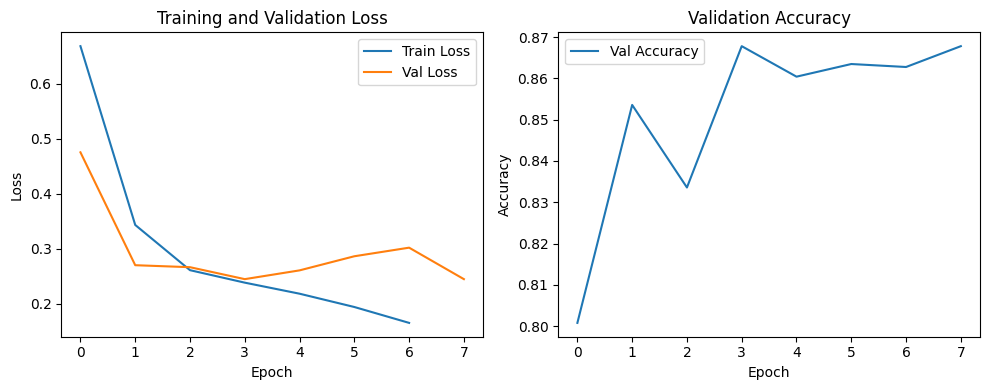

In [12]:
train_dataset = HybridCourtDataset(train_texts, train_labels, train_metadata, tokenizer)
val_dataset = HybridCourtDataset(val_texts, val_labels, val_metadata, tokenizer)

model = HybridRobertaClassifier(num_metadata_features=num_metadata_features)

training_args = TrainingArguments(
    output_dir="./temp_hybrid_model",
    num_train_epochs=10,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=16,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=2e-5,
    report_to="none",
    weight_decay=0.01,
    lr_scheduler_type="linear",
    warmup_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    use_cpu=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

print("Starting training...")
trainer.train()

print("\nEvaluating model...")
metrics = trainer.evaluate()

logs = trainer.state.log_history
train_loss = [log["loss"] for log in logs if "loss" in log]
val_loss = [log["eval_loss"] for log in logs if "eval_loss" in log]
val_acc = [log["eval_accuracy"] for log in logs if "eval_accuracy" in log]

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Val Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_acc, label="Val Accuracy")
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
print("\n" + "="*60)
print("HYBRID MODEL - TRAINING RESULTS")
print("="*60)
print(f"\nValidation Accuracy: {metrics['eval_accuracy']:.4f}")
print(f"Validation F1 Score: {metrics['eval_f1']:.4f}")
print(f"Validation Loss: {metrics['eval_loss']:.4f}")


HYBRID MODEL - TRAINING RESULTS

Validation Accuracy: 0.8678
Validation F1 Score: 0.8677
Validation Loss: 0.2446


In [14]:
import pickle

final_model_path = "./hybrid_roberta_model"
os.makedirs(final_model_path, exist_ok=True)

# Save model weights
torch.save(model.state_dict(), os.path.join(final_model_path, "model_state.pt"))

# Save tokenizer
tokenizer.save_pretrained(final_model_path)

# Save encoders and scaler
with open(os.path.join(final_model_path, "offence_encoder.pkl"), "wb") as f:
    pickle.dump(offence_encoder, f)
with open(os.path.join(final_model_path, "offence_sub_encoder.pkl"), "wb") as f:
    pickle.dump(offence_sub_encoder, f)
with open(os.path.join(final_model_path, "scaler.pkl"), "wb") as f:
    pickle.dump(scaler, f)

print(f"\nModel saved to {final_model_path}")
print(f"  - model_state.pt")
print(f"  - tokenizer files")
print(f"  - offence_encoder.pkl")
print(f"  - offence_sub_encoder.pkl")
print(f"  - scaler.pkl")


Model saved to ./hybrid_roberta_model
  - model_state.pt
  - tokenizer files
  - offence_encoder.pkl
  - offence_sub_encoder.pkl
  - scaler.pkl
